In [1]:
import extractors as ext
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from extractors import WordExtractor, FeatureExtractor, Features
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Définition de méthodes

In [2]:
# Crée automatiquement les caractéristiques et les cibles à partir du document.
def get_data(n_word:int, stem:bool, use_stopword:bool) -> Tuple[List[List[any]], List[int]]:
    if use_stopword:
        stopwords = ext.read_stopwords_to_regex("stopwords.txt")
    else:
        stopwords = None

    word_ext = WordExtractor(stopwords, stem)
    feature_ext = FeatureExtractor(n_word, True)

    features = ext.extract_features(word_ext, feature_ext, "testing_doc.txt", "filename")
    data = features.get_features(["BagOfWords", "CatsOnehot"])
    targets = features.get_targets()
    return data, targets


In [3]:
# Split the data into training, validation and testing set with (0.50, 0.25, 0.25)
def split_data(data, targets):
    X_temp, X_test, y_temp, y_test = train_test_split(data, targets, train_size=0.75, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, train_size=0.66, shuffle=True)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [4]:
def display_confusion_matrix(confusion_matrix, labels=['1', '2', '3', '4', '5', '6']):
    display = ConfusionMatrixDisplay(confusion_matrix, display_labels = labels)
    display.plot()
    plt.show()

## Entrainement du réseau de neurones
L'entrainement du réseau de neurone se fait par la classe CustomGridSearch. La classe implémente une recherche en grille pour les meilleurs valeurs de profondeur et largeur du réseau.

On utilise la fonction d'activation sigmoid pour tous les MLP. L'optimisation se fait par descente de grandient stochastique, avec un taux d'apprentissage constant (fixé à 0.05).

In [5]:
# Create the MLP with a set of default parameters, only taking the network size as an argument
def create_MLP(depth, width) -> MLPClassifier:
    hidden_layers = [width for _ in range(0, depth)]

    return MLPClassifier(hidden_layer_sizes=hidden_layers, activation='logistic', solver='sgd', learning_rate='adaptive', learning_rate_init=0.1, max_iter=2000)

In [6]:
# Custom class to do grid search
class CustomGridSearch:

    def __init__(self, min_depth:int, max_depth:int, min_width:int, max_width:int, depth_step:int = 1, width_step:int = 1):
        hidden_layers_matrix = [[(depth, width) for width in range(min_width, max_width, width_step)] for depth in range(min_depth, max_depth, depth_step)]
        self.hidden_layers_matrix = np.array(hidden_layers_matrix)

        self.estimators = np.empty(self.hidden_layers_matrix.shape[0:2], dtype=object)
        self.confusion_matrixes = np.empty(self.hidden_layers_matrix.shape[0:2], dtype=object)
        self.accuracies = np.zeros(self.hidden_layers_matrix.shape[0:2])
        self.scores = np.zeros(self.hidden_layers_matrix.shape[0:2])
        pass

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid

        for i in range(0, len(self.hidden_layers_matrix)):
            for j in range(0, len(self.hidden_layers_matrix[0])):
                self.__run_estimator(i, j)
        return self

    def argmax(self, metric: str) -> Tuple[int,int]:
        if metric == 'score' or metric == 'f1_score':
            metric_matrix:np.ndarray = self.scores
        elif metric == 'accuracy':
            metric_matrix:np.ndarray = self.accuracies

        index = metric_matrix.argmax()
        row = int(index / metric_matrix.shape[1])
        col = int(index % metric_matrix.shape[1])
        
        return row, col

    def max(self, metric: str) -> Tuple[int,int]:
        row, col = self.argmax(metric)
        return self.hidden_layers_matrix[row, col, 0], self.hidden_layers_matrix[row, col, 1]

    def plot_results(self, metric: str, axis:str='width'):
        plt.xlabel(axis)
        plt.ylabel(metric)

        if metric == 'score' or metric == 'f1_score':
            metric_matrix:np.ndarray = self.scores
        elif metric == 'accuracy':
            metric_matrix:np.ndarray = self.accuracies

        if axis == 'width':
            for i in range(0, self.hidden_layers_matrix.shape[0]):
                depth = self.hidden_layers_matrix[i,0,0]

                widths = self.hidden_layers_matrix[i,:,1]
                metrics = metric_matrix[i,:]

                plt.plot(widths, metrics, label=depth)
        elif axis == 'depth':
            for i in range(0, self.hidden_layers_matrix.shape[1]):
                width = self.hidden_layers_matrix[0,i,1]

                depths = self.hidden_layers_matrix[:,i,0]
                metrics = metric_matrix[:,i]

                plt.plot(depths, metrics, label=width)

        plt.legend()
        plt.show()
        pass

    def __run_estimator(self, i, j):
        depth = self.hidden_layers_matrix[i,j,0]
        width = self.hidden_layers_matrix[i,j,1]

        estimator: MLPClassifier = create_MLP(depth, width).fit(self.X_train, self.y_train)
        y_preds = estimator.predict(self.X_valid)

        accuracy = accuracy_score(self.y_valid, y_preds, normalize=True)
        score = f1_score(self.y_valid, y_preds, average='macro')
        matrix = confusion_matrix(self.y_valid, y_preds, labels=['1', '2', '3', '4', '5', '6'])

        # Place in the scores matrixes
        self.accuracies[i,j] = accuracy
        self.scores[i,j] = score
        self.confusion_matrixes[i,j] = matrix
        self.estimators[i,j] = estimator
        pass

## Évaluation
On évalue une technique d'extraction des features en la testant sur des réseaux de différentes tailles, avec différentes tailles de fenêtres.

### Évaluation des features
L'évaluation des features teste des réseaux de perceptron sur un même objet Features. On test pour un nombre variable de pronfondeur et de largeur du réseau et on regarde le meilleur résultat.

Pour évaluer les résultats, on sépare les données en ensemble d'entrainement, de validation et de test. La séparation est 0.5, 0.25, 0.25 respectivement

Les résultats sont comparés en utilisant leur précisions sur l'ensemble de validation. On regardant aussi la précision du meilleur estimateur sur l'ensemble de test.

La méthode retourne le meilleur estimateur, ainsi que son score sur l'ensemble de validation et de test.

In [7]:
def evaluate_features(features:Features) -> Tuple[MLPClassifier, float, float]:
    data = np.array(features.get_features(["BagOfWords", "CatsOnehot"]))
    targets = np.array(features.get_targets())
    print("Data: ", data.shape)

    # Separate the data into training, validation and test set
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(data, targets)
    print("Train: ", X_train.shape)
    print("Valid: ", X_valid.shape)
    print("Test: ", X_test.shape)
    print("--------------------")
    
    searcher = CustomGridSearch(1, 6, 1, 11, width_step=1)
    searcher.fit(X_train, y_train, X_valid, y_valid)

    best_depth, best_width = searcher.max(metric='accuracy')
    row, col = searcher.argmax(metric='accuracy')

    # Display result
    print("Best accuracy on validation is ", round(searcher.accuracies[row, col]*100,3), "% with (", best_depth, ",", best_width, ")", sep="")
    print("Confusion matrix is")
    train_conf_matrix = searcher.confusion_matrixes[row, col]
    display_confusion_matrix(train_conf_matrix)
    print("--------------------")

    # Plot
    searcher.plot_results(metric='accuracy', axis='width')
    print("--------------------")

    # Evaluate on testing set
    estimator: MLPClassifier = searcher.estimators[row, col]
    y_preds = estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_preds, normalize=True)
    print("Accuracy on testing set is ", round(test_accuracy*100,3), "%", sep="")

    print("Confusion matrix is")
    test_conf_matrix = confusion_matrix(y_test, y_preds, labels=['1', '2', '3', '4', '5', '6'])
    display_confusion_matrix(test_conf_matrix)
    
    return estimator, searcher.accuracies[row, col], test_accuracy

Data:  (2368, 2442)
Train:  (1172, 2442)
Valid:  (604, 2442)
Test:  (592, 2442)
--------------------
Best accuracy on validation is 0.7880794701986755% with (1,9)
Confusion matrix is


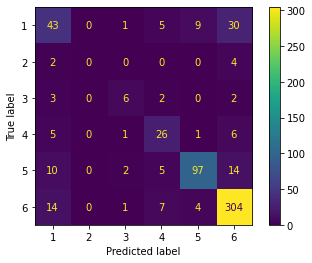

--------------------


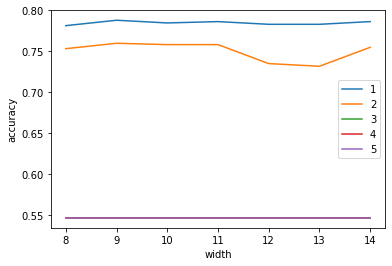

--------------------
Accuracy on testing set is 0.7635135135135135%
Confusion matrix is


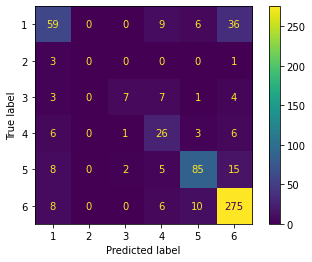

(MLPClassifier(activation='logistic', hidden_layer_sizes=[9],
               learning_rate='adaptive', learning_rate_init=0.1, max_iter=2000,
               solver='sgd'),
 0.7880794701986755,
 0.7635135135135135)

In [12]:
# Testing
w_extractor:WordExtractor = WordExtractor()
f_extractor:FeatureExtractor = FeatureExtractor(n_word = 2, add_padding = True)

feats:Features = ext.extract_features(w_extractor, f_extractor, "interest.txt", "filename")
evaluate_features(feats)

### Évaluation de la taille des fenêtres
On chercher à évaluer différentes tailles de fenêtre pour la sélection des features. La taille de la fenêtre correspond au nombre de mot avant et après la cible choisis dans chaque phrase.

La méthode retourne le meilleur estimateur ainsi que son erreur sur l'ensemble de test.

In [9]:
def evaluate_feature_extraction(word_extractor:WordExtractor, input:str, input_type:str = 'filename') -> Tuple[MLPClassifier, float]:
    words_before, words_after, targets = word_extractor.extract(input, input_type)

    test_size = [1, 2, 3, 4, 5]

    # Contains the best estimator at each iteration
    estimators:List[MLPClassifier] = []
    valid_accuracies:np.ndarray = np.zeros(len(test_size))
    test_accuracies:np.ndarray = np.zeros(len(test_size))

    for i, size in enumerate(test_size):
        feature_extractor = FeatureExtractor(n_word=size, add_padding=True)
        features = feature_extractor.extract(words_before, words_after, targets)
        print("Testing for window size ", size, "\n")

        # Evaluate the features
        estimator, valid_accuracy, test_accuracy = evaluate_features(features)
        estimators.append(estimator)
        valid_accuracies[i] = valid_accuracy
        test_accuracies[i] = test_accuracy

        print("\n====================\n")

    # Find the best estimator
    best_i = valid_accuracies.argmax()
    best_size = test_size[best_i]
    best_accuracy = valid_accuracies[best_i]
    print("The best accuracy is ", round(best_accuracy*100,3), "% at size ", best_size, sep="")
    print("--------------------")

    # Plot the result
    plt.xlabel("Window size")
    plt.ylabel("Accuracy")

    plt.plot(test_size, valid_accuracies)
    plt.show()

    # Look at the test accuracy
    print("Accuracy on the testing set is ", round(test_accuracies[best_i]*100,3), "%", sep="")
    return estimators[best_i], test_accuracies[best_i]

In [ ]:
# Testing
word_extractor:WordExtractor = WordExtractor()
evaluate_feature_extraction(word_extractor, 'testing_doc.txt', 'filename')

: 

## Extraction des features
On teste différentes techniques d'extractions de features.

1. Cas de base : on garde tous les mots
2. Stopwords : on enlève les stopwords du texte
3. Stemming : on fait du stemming sur les mots gardés

In [10]:
def evaluate_word_extractor(word_extractor:WordExtractor):
    evaluate_feature_extraction(word_extractor, input='interest.txt', input_type='filename')

Testing for window size  1 

Data:  (2368, 1454)
Train:  (1172, 1454)
Valid:  (604, 1454)
Test:  (592, 1454)
--------------------
Best accuracy on validation is 77.649% with (1,5)
Confusion matrix is


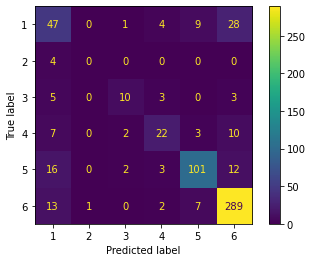

--------------------


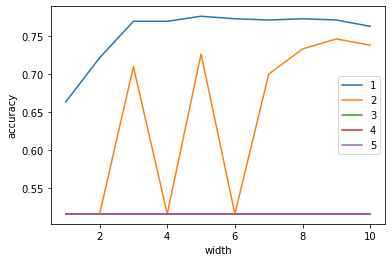

--------------------
Accuracy on testing set is 74.493%
Confusion matrix is


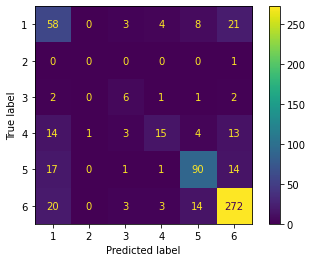



Testing for window size  2 

Data:  (2368, 2442)
Train:  (1172, 2442)
Valid:  (604, 2442)
Test:  (592, 2442)
--------------------
Best accuracy on validation is 78.808% with (1,8)
Confusion matrix is


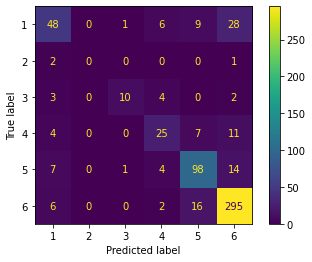

--------------------


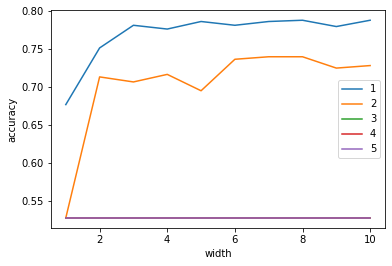

--------------------
Accuracy on testing set is 79.899%
Confusion matrix is


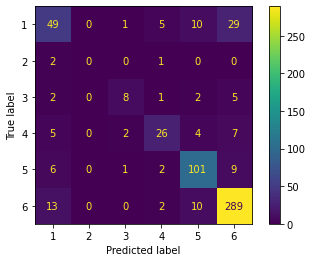



Testing for window size  3 

Data:  (2368, 3184)
Train:  (1172, 3184)
Valid:  (604, 3184)
Test:  (592, 3184)
--------------------
Best accuracy on validation is 80.96% with (1,5)
Confusion matrix is


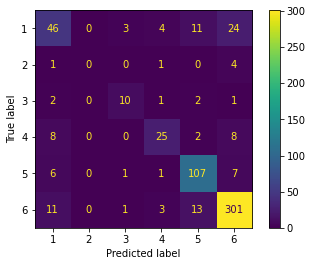

--------------------


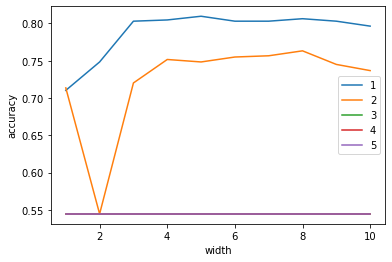

--------------------
Accuracy on testing set is 78.885%
Confusion matrix is


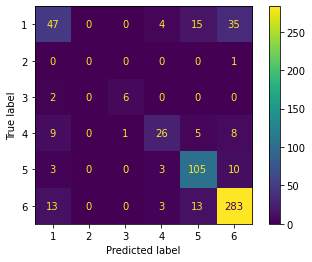



Testing for window size  4 

Data:  (2368, 3842)
Train:  (1172, 3842)
Valid:  (604, 3842)
Test:  (592, 3842)
--------------------
Best accuracy on validation is 78.477% with (1,5)
Confusion matrix is


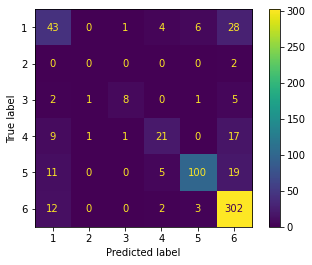

--------------------


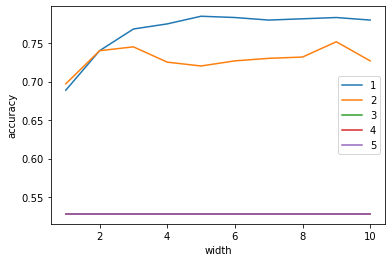

--------------------
Accuracy on testing set is 78.547%
Confusion matrix is


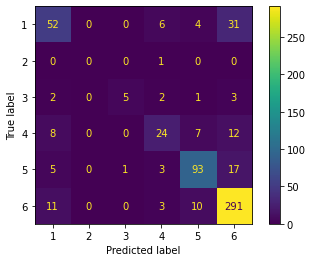



Testing for window size  5 

Data:  (2368, 4397)
Train:  (1172, 4397)
Valid:  (604, 4397)
Test:  (592, 4397)
--------------------
Best accuracy on validation is 79.636% with (1,7)
Confusion matrix is


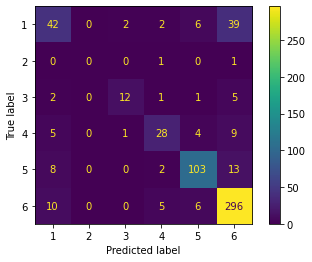

--------------------


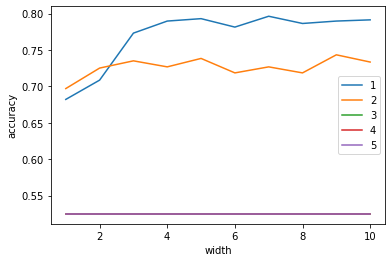

--------------------
Accuracy on testing set is 78.716%
Confusion matrix is


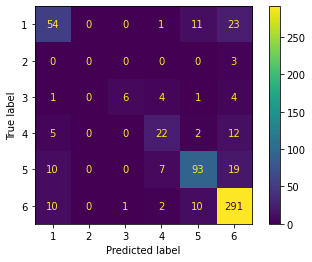



The best accuracy is 80.96% at size 3
--------------------


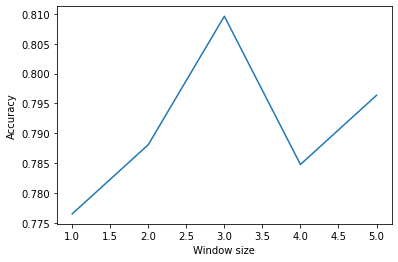

Accuracy on the testing set is 78.885%


In [11]:
# Base case
word_extractor = WordExtractor()
evaluate_word_extractor(word_extractor)

Testing for window size  1 

Data:  (2368, 1692)
Train:  (1172, 1692)
Valid:  (604, 1692)
Test:  (592, 1692)
--------------------
Best accuracy on validation is 76.325% with (1,7)
Confusion matrix is


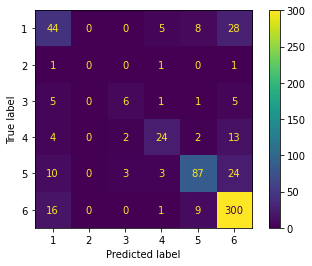

--------------------


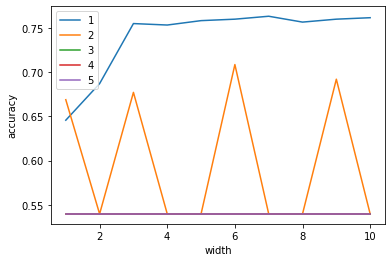

--------------------
Accuracy on testing set is 78.885%
Confusion matrix is


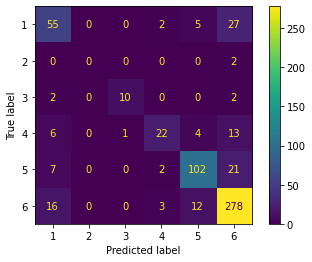



Testing for window size  2 

Data:  (2368, 3030)
Train:  (1172, 3030)
Valid:  (604, 3030)
Test:  (592, 3030)
--------------------
Best accuracy on validation is 79.139% with (1,6)
Confusion matrix is


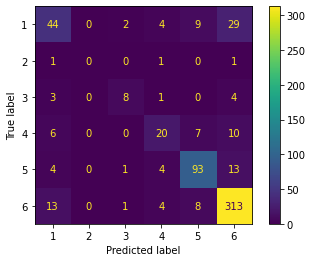

--------------------


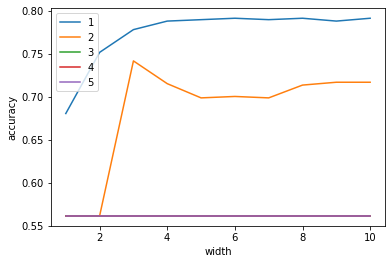

--------------------
Accuracy on testing set is 76.182%
Confusion matrix is


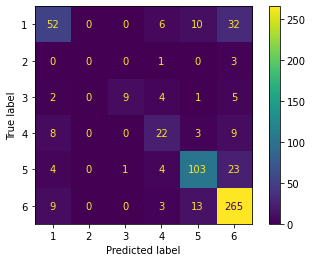



Testing for window size  3 

Data:  (2368, 3988)
Train:  (1172, 3988)
Valid:  (604, 3988)
Test:  (592, 3988)
--------------------
Best accuracy on validation is 79.305% with (1,7)
Confusion matrix is


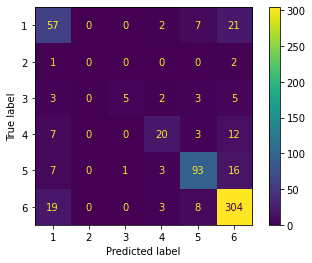

--------------------


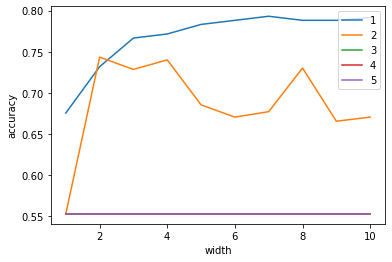

--------------------
Accuracy on testing set is 78.041%
Confusion matrix is


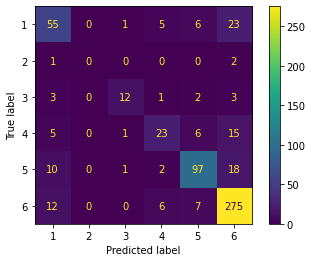



Testing for window size  4 

Data:  (2368, 4785)
Train:  (1172, 4785)
Valid:  (604, 4785)
Test:  (592, 4785)
--------------------
Best accuracy on validation is 76.656% with (1,5)
Confusion matrix is


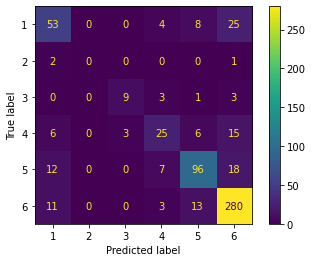

--------------------


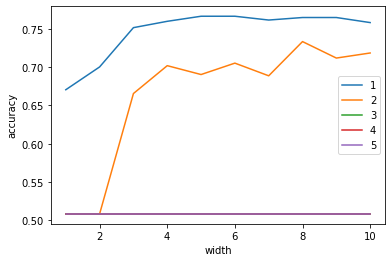

--------------------
Accuracy on testing set is 80.236%
Confusion matrix is


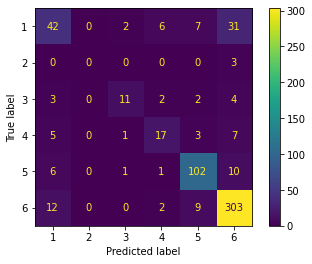



Testing for window size  5 

Data:  (2368, 5396)
Train:  (1172, 5396)
Valid:  (604, 5396)
Test:  (592, 5396)
--------------------
Best accuracy on validation is 79.967% with (1,7)
Confusion matrix is


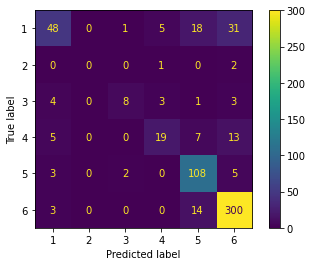

--------------------


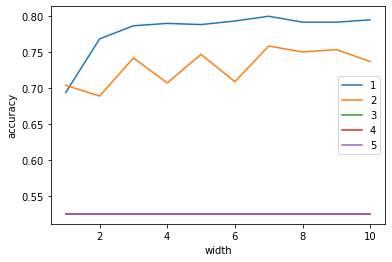

--------------------
Accuracy on testing set is 80.743%
Confusion matrix is


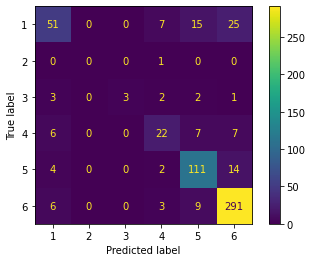



The best accuracy is 79.967% at size 5
--------------------


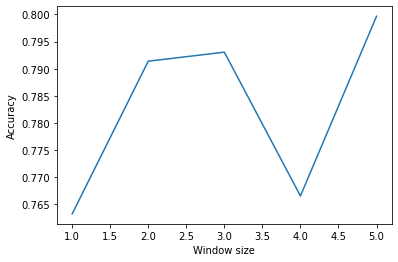

Accuracy on the testing set is 80.743%


In [12]:
# With stopwords
stopwords = ext.read_stopwords_to_regex('stopwords.txt')

word_extractor = WordExtractor(stopwords=stopwords)
evaluate_word_extractor(word_extractor)

Testing for window size  1 

Data:  (2368, 1398)
Train:  (1172, 1398)
Valid:  (604, 1398)
Test:  (592, 1398)
--------------------
Best accuracy on validation is 80.132% with (1,8)
Confusion matrix is


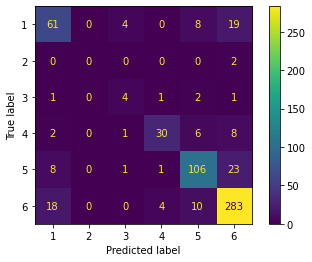

--------------------


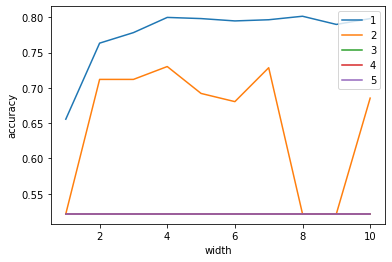

--------------------
Accuracy on testing set is 75.338%
Confusion matrix is


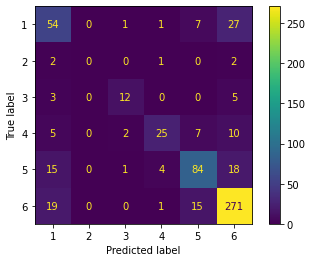



Testing for window size  2 

Data:  (2368, 2452)
Train:  (1172, 2452)
Valid:  (604, 2452)
Test:  (592, 2452)
--------------------
Best accuracy on validation is 78.642% with (1,4)
Confusion matrix is


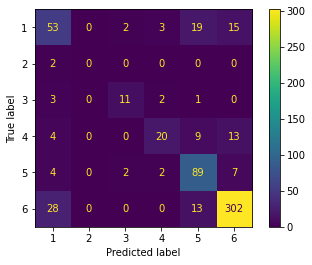

--------------------


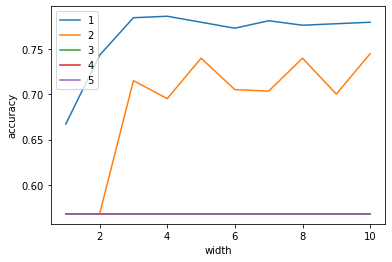

--------------------
Accuracy on testing set is 77.703%
Confusion matrix is


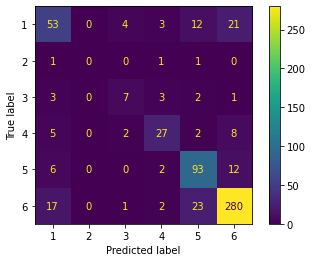



Testing for window size  3 

Data:  (2368, 3148)
Train:  (1172, 3148)
Valid:  (604, 3148)
Test:  (592, 3148)
--------------------
Best accuracy on validation is 80.298% with (1,4)
Confusion matrix is


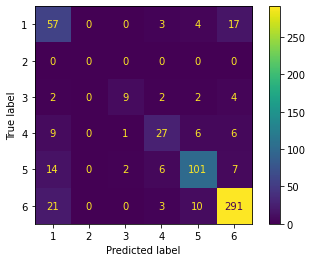

--------------------


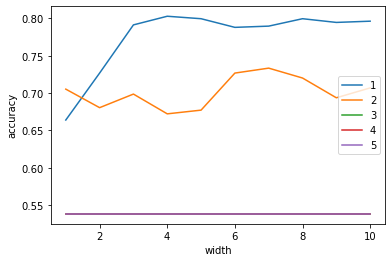

--------------------
Accuracy on testing set is 79.392%
Confusion matrix is


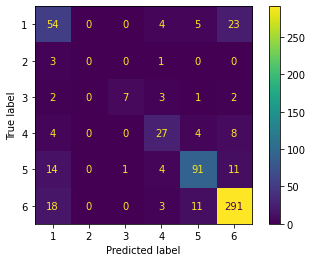



Testing for window size  4 

Data:  (2368, 3761)
Train:  (1172, 3761)
Valid:  (604, 3761)
Test:  (592, 3761)
--------------------
Best accuracy on validation is 81.126% with (1,4)
Confusion matrix is


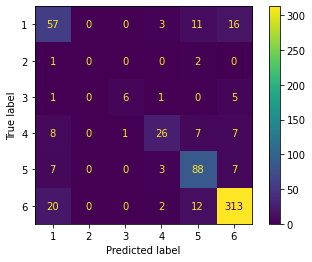

--------------------


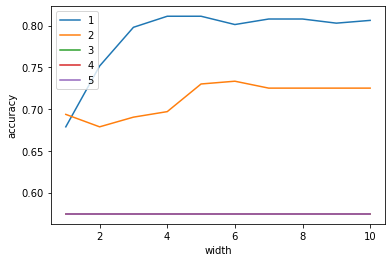

--------------------
Accuracy on testing set is 79.561%
Confusion matrix is


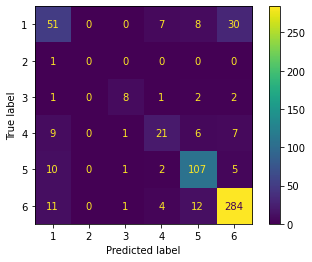



Testing for window size  5 

Data:  (2368, 4223)
Train:  (1172, 4223)
Valid:  (604, 4223)
Test:  (592, 4223)
--------------------
Best accuracy on validation is 79.305% with (1,9)
Confusion matrix is


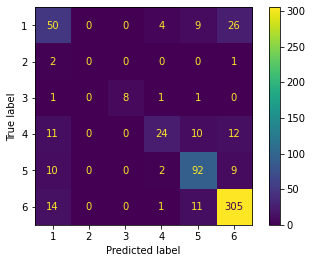

--------------------


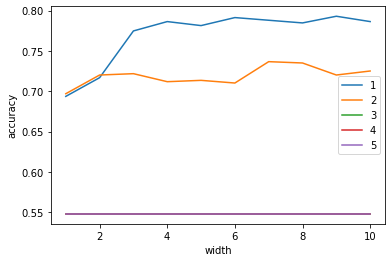

--------------------
Accuracy on testing set is 80.236%
Confusion matrix is


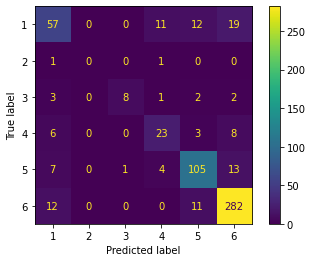



The best accuracy is 81.126% at size 4
--------------------


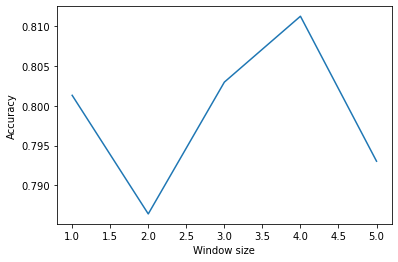

Accuracy on the testing set is 79.561%


In [13]:
# With stemming
stopwords = ext.read_stopwords_to_regex('stopwords.txt')

word_extractor = WordExtractor(stopwords=stopwords, stem=True)
evaluate_word_extractor(word_extractor)

## Other

In [ ]:
# Get the data
data, targets = get_data(n_word=3, stem=False, use_stopword=False)

data = np.array(data)
targets = np.array(targets)

print(data.shape)

# Separate the data into training, validation and test set
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(data, targets)

print("Train: ", X_train.shape)
print("Valid: ", X_valid.shape)
print("Test: ", X_test.shape)

: 

In [ ]:
searcher = CustomGridSearch(5, 9, 300, 700, width_step=100)
print(searcher.hidden_layers_matrix)

searcher.fit(X_train, y_train, X_valid, y_valid)

: 